##Calculating Texture and Dealiasing



In [2]:
import pyart
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage, signal
import time
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


/usr/lib/python3.4/json/encoder.py:192: DeprecationWarning: Interpreting naive datetime as local 2017-06-18 17:46:25.330017. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
radar = pyart.io.read('./data/csapr_test_case.nc')

Data available by FigShare Here: http://figshare.com/articles/Data_for_AMS_Short_Course_on_Open_Source_Radar_Software/1537461
Download and unpack into the data subdirectory of this repository 

In [ ]:
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]

display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    vmin = -nyq, vmax = nyq, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel)


In [6]:
start_time = time.time()
data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
                                            pyart.util.interval_std, size = (4,4),
                                           extra_arguments = (-nyq, nyq))
total_time = time.time() - start_time
print(total_time)


266.757094145


In [1]:
filtered_data = ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
radar.add_field('velocity_texture', texture_field, replace_existing = True)

NameError: name 'ndimage' is not defined

In [ ]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity_texture', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 14)


In [9]:
n, bins = np.histogram(filtered_data.flatten(), bins = 150)

In [10]:
peaks = signal.find_peaks_cwt(n, np.array([10]))
centers = bins[0:-1] + (bins[1] - bins[0])
search_data = n[peaks[0]:peaks[1]]
search_centers = centers[peaks[0]:peaks[1]]
locs = search_data.argsort()
location_of_minima = locs[0]

4.59590638749


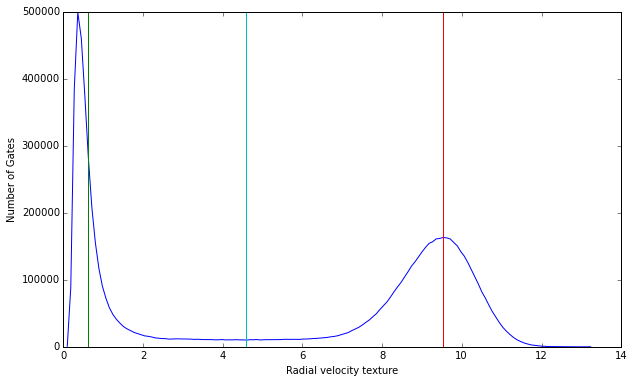

In [11]:
fig = plt.figure(figsize = [10,6])
plt.plot(centers, n)
zmax = n.max()
plt.xlabel('Radial velocity texture')
plt.ylabel('Number of Gates')

plt.plot([centers[peaks[0]], centers[peaks[0]]], [0, zmax])
plt.plot([centers[peaks[1]], centers[peaks[1]]], [0, zmax])
plt.plot([search_centers[location_of_minima], search_centers[location_of_minima]], [0, zmax])
noise_threshold = search_centers[locs[0]]
print(noise_threshold)

In [12]:
likely_noise = filtered_data > noise_threshold
likely_signal = np.logical_not(likely_noise)


In [13]:
z_masked = np.ma.masked_where(likely_noise, radar.fields['reflectivity']['data'])
radar.add_field_like('reflectivity', 
                     'reflectivity_masked', 
                     z_masked, replace_existing = True)


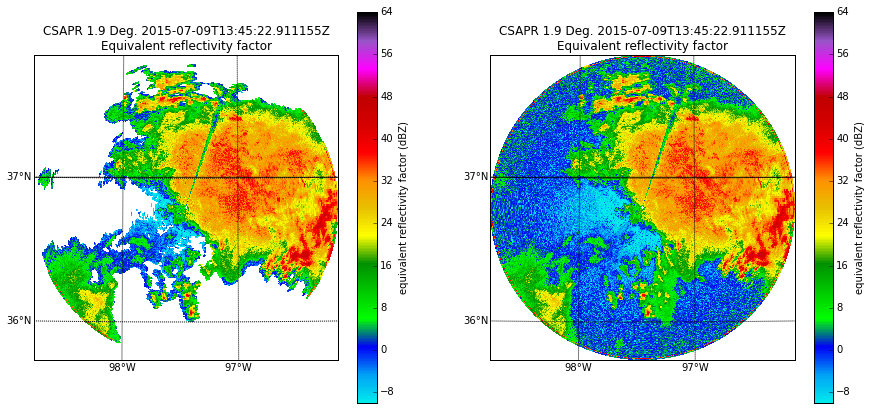

In [14]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('reflectivity_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)
plt.subplot(1,2,2)
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 64)


In [15]:
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_masked('reflectivity_masked')

In [16]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field='velocity', keep_original=False, 
    gatefilter = gatefilter, nyquist_vel=nyq, centered = True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

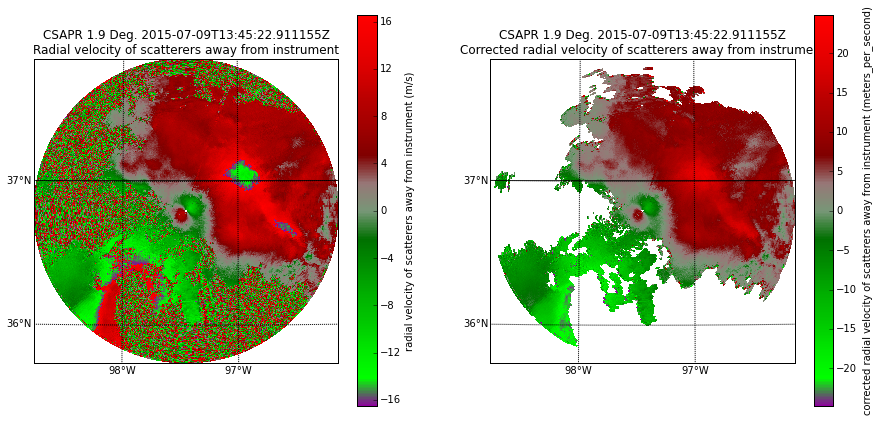

In [17]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [15,7])
plt.subplot(1,2,1)
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -nyq, vmax = nyq)
plt.subplot(1,2,2)
display.plot_ppi_map('corrected_velocity', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel,
                    vmin = -1.5*nyq, vmax = 1.5*nyq)
